This notebook uses the TensorFlow library to train a Deep Cross Network (DCN) model on the MovieLens 1M dataset.
- The DCN model is a type of neural network that is used for recommendation systems.First we load the movielens dataset and preprocesses it by mapping certain features, such as movie_id, user_id, and user_rating. 
- Then we shuffle and split the data into training and test sets. 
- Next, we define feature names and compute embeddings for string and integer features using the TensorFlow Sequential API and the StringLookup and IntegerLookup layers.
- Train a DCN model using different layer size  to find optimun layer size combination.
- Train DCN with a layer size of [256,256,256] first using a cross layer and then without a cross layer to asses the impact of the cross layer on the model.
- Define a function that detects popularity bias.
- Show correlation of cross features.
- Explore exposure bias

In [2]:
import os
import pprint
import tempfile
from typing import Dict, Text
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [4]:
# Load the movielens dataset
ratings = tfds.load("movielens/1m-ratings", split="train")
movies = tfds.load("movielens/1m-movies", split="train")

In [5]:
ratings = tfds.load("movielens/1m-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

In [6]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [7]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [8]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
  loss=tf.keras.losses.MeanSquaredError(),
  metrics=[tf.keras.metrics.RootMeanSquaredError()]
      

)

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
        embedding = self._embeddings[feature_name](features[feature_name])
        print(f'embedding shape: {embedding.shape}')
        embedding = tf.reshape(embedding, (-1, self.embedding_dimension))
        embeddings.append(embedding)
    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)

    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [9]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [10]:
# Instantiate the model
use_cross_layer = True
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(cached_train,validation_data=cached_test, epochs=100,)


Epoch 1/100
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
 9/10 [==========================>...] - ETA: 0s - root_mean_squared_error: 2.6924 - loss: 7.2488 - regularization_loss: 0.0000e+00 - total_loss: 7.2488embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
10/10 [==============================] - 6s 354ms/step - root_mean_squared_error: 2.6046 - loss: 6.1713 - regularization_loss: 0.0000e+00 - total_loss: 6.1713 - val_root_mean_squared_error: 1.1453 - val_loss: 1.3151 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.3151
Epoch 2/100
10/10 [==============================] - 

In [11]:
print(history.history.keys())

dict_keys(['root_mean_squared_error', 'loss', 'regularization_loss', 'total_loss', 'val_root_mean_squared_error', 'val_loss', 'val_regularization_loss', 'val_total_loss'])


### Effect of Cross layer on DCN

 one way to check if the cross layer is introducing bias into the model is to evaluate the model's performance on a diverse set of data. The MovieLens dataset is a good starting point as it contains a diverse set of users, however, it is important to evaluate the model's performance on other datasets that have different characteristics.
 Another way to check if the cross layer is introducing bias is to evaluate the model's performance on specific sub-groups within the data. For example, one could evaluate the model's performance on users of different genders, age groups, or occupation groups.

Additionally, you could evaluate the model's performance by looking at the distribution of the predicted scores for different sub-groups. If the distribution is skewed for certain sub-groups, it could indicate that the model is introducing bias.
It's also good to keep in mind that bias can also be introduced by the preprocessing and feature engineering steps, so it's important to evaluate the input data and feature set as well.
Another approach would be to check the performance of the model on different subsets of the data, such as by user gender, zip code, occupation, or age. If the model performs significantly better for one subset of the data over others, it could indicate that the cross layer is introducing bias.

In [11]:
train_acc = model.evaluate(
    cached_train, return_dict=True)
test_acc = model.evaluate(
    cached_test, return_dict=True)


print(f'DCN with cross layer (train): {train_acc["root_mean_squared_error"]:.2f}')
print(f'DCN with cross layer (test): {test_acc["root_mean_squared_error"]:.2f}')

5/5 [==============================] - 0s 6ms/step - root_mean_squared_error: 0.9493 - loss: 0.8982 - regularization_loss: 0.0000e+00 - total_loss: 0.8982
DCN with cross layer (train): 0.85
DCN with cross layer (test): 0.95


In [19]:
ratings_df = tfds.as_dataframe(ratings)
ratings_df.head()

bucketized_user_age movie_id  user_gender  user_id  \
0                   35  b'3107'            1   b'130'   
1                   25  b'2114'            0  b'3829'   
2                   18   b'256'            0  b'1265'   
3                   18  b'1389'            1  b'2896'   
4                   18  b'3635'            1  b'5264'   

      user_occupation_text  user_rating user_zip_code  
0   b'technician/engineer'          5.0      b'50021'  
1     b'academic/educator'          4.0      b'22307'  
2                b'writer'          1.0      b'49321'  
3       b'sales/marketing'          5.0      b'60073'  
4  b'college/grad student'          4.0      b'15217'

In [20]:
bucketized_user_age = ratings_df['bucketized_user_age'].unique()
user_occupation_text = ratings_df['user_occupation_text'].unique()

print(bucketized_user_age)
print(user_occupation_text)


[35 25 18 45 50 56  1]
[b'technician/engineer' b'academic/educator' b'writer' b'sales/marketing'
 b'college/grad student' b'artist' b'executive/managerial' b'programmer'
 b'retired' b'other/not specified' b'unemployed' b'self-employed'
 b'doctor/health care' b'K-12 student' b'lawyer' b'scientist'
 b'clerical/admin' b'customer service' b'homemaker' b'tradesman/craftsman'
 b'farmer']


In [39]:


# # Create occupation groups
# occupation_groups = {
#     "technical": ["b'technician/engineer'", "b'programmer'", "b'scientist'"],
#     "education": [" b'academic/educator'", "b'college/grad student", "b'K-12 student"],
#     "creative": ["b'writer", "b'artist"],
#     "business": ["b'sales/marketing", "b'executive/managerial", "b'lawyer"],
#     "service": ["b'clerical/admin", "b'customer service", "b'homemaker"],
#     "other": ["b'retired", "b'other/not specified", "b'unemployed", "b'self-employed", "b'farmer", "b'tradesman/craftsman"],
# }


# occupation_groups = {
# "technical": ["technician/engineer", "programmer", "scientist"],
# "education": ["academic/educator", "college/grad student", "K-12 student"],
# "creative": ["writer", "artist"],
# "business": ["sales/marketing", "executive/managerial", "lawyer"],
# "service": ["clerical/admin", "customer service", "homemaker"],
# "other": ["retired", "other/not specified", "unemployed", "self-employed", "farmer", "tradesman/craftsman"],
# }

In [40]:
# occupation_group_lists = {key: [] for key in occupation_groups.keys()}
# for i, user in ratings_df.iterrows():
#     occupation = user['user_occupation_text']
#     for group, occupations in occupation_groups.items():
#         if occupation in occupations:
#             occupation_group_lists[group].append(i)


In [44]:
# print(occupation_group_lists)

In [45]:
# engineer_users = ratings_df[ratings_df['user_occupation_text'] == "b'technician/engineer"]
# print(engineer_users)

In [49]:
# Create a dataset with only the young users (age 18-24)
young_users = ratings.filter(lambda x: x['bucketized_user_age'] >= 18 and x['bucketized_user_age'] <= 24)

# Create a dataset with only the middle aged users (age 35-44)
middle_aged_users = ratings.filter(lambda x: x['bucketized_user_age'] >= 35 and x['bucketized_user_age'] <= 44)


In [50]:
# Instantiate the model
use_cross_layer = True
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(young_users,epochs=10)


Epoch 1/10
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
183536/183536 [==============================] - 431s 2ms/step - root_mean_squared_error: 0.9666 - loss: 0.9344 - regularization_loss: 0.0000e+00 - total_loss: 0.9344
Epoch 2/10
183536/183536 [==============================] - 428s 2ms/step - root_mean_squared_error: 0.9144 - loss: 0.8362 - regularization_loss: 0.0000e+00 - total_loss: 0.8362
Epoch 3/10
183536/183536 [==============================] - 421s 2ms/step - root_mean_squared_error: 0.8915 - loss: 0.7949 - regularization_loss: 0.0000e+00 - total_loss: 0.7949
Epoch 4/10
183536/183536 [==============================] - 422s 2ms/step - root_mean_squared_error: 0.8674 - loss: 0.7524 - regularization_loss: 0.0000e+00 - total_loss: 0.7524
Epoch 5/10
1

In [52]:
young_users = model.evaluate(
    young_users, return_dict=True)

embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
183536/183536 [==============================] - 280s 2ms/step - root_mean_squared_error: 0.8152 - loss: 0.6645 - regularization_loss: 0.0000e+00 - total_loss: 0.6645


In [53]:
print(f'DCN with cross layer young_users: {young_users["root_mean_squared_error"]:.2f}')

DCN with cross layer young_users: 0.82


In [54]:
history=model.fit(middle_aged_users,epochs=10)


Epoch 1/10
199003/199003 [==============================] - 459s 2ms/step - root_mean_squared_error: 0.8982 - loss: 0.8068 - regularization_loss: 0.0000e+00 - total_loss: 0.8068
Epoch 2/10
199003/199003 [==============================] - 456s 2ms/step - root_mean_squared_error: 0.8464 - loss: 0.7165 - regularization_loss: 0.0000e+00 - total_loss: 0.7165
Epoch 3/10
199003/199003 [==============================] - 447s 2ms/step - root_mean_squared_error: 0.8190 - loss: 0.6708 - regularization_loss: 0.0000e+00 - total_loss: 0.6708
Epoch 4/10
199003/199003 [==============================] - 450s 2ms/step - root_mean_squared_error: 0.7938 - loss: 0.6301 - regularization_loss: 0.0000e+00 - total_loss: 0.6301
Epoch 5/10
199003/199003 [==============================] - 453s 2ms/step - root_mean_squared_error: 0.7683 - loss: 0.5903 - regularization_loss: 0.0000e+00 - total_loss: 0.5903
Epoch 6/10
199003/199003 [==============================] - 455s 2ms/step - root_mean_squared_error: 0.7428 - 

In [55]:
middle_aged_users = model.evaluate(
    middle_aged_users, return_dict=True)

199003/199003 [==============================] - 513s 3ms/step - root_mean_squared_error: 0.6887 - loss: 0.4744 - regularization_loss: 0.0000e+00 - total_loss: 0.4744


In [56]:
print(f'DCN with cross layer middle_aged_users: {middle_aged_users["root_mean_squared_error"]:.2f}')

DCN with cross layer middle_aged_users: 0.69


In [ ]:

# # Create a dataset containing only users with occupation 'technician/engineer'
# engineer_users = ratings_df[ratings_df['user_occupation_text'] == 'technician/engineer']

# # Create a dataset containing only users with occupation 'writer'
# writer_users = ratings_df[ratings_df['user_occupation_text'] == 'writer']

In [12]:
# Create a dataset containing only male users
male_users = ratings.filter(lambda x: x["user_gender"] == 1)

# Create a dataset containing only female users
female_users = ratings.filter(lambda x: x["user_gender"] == 0)



In [13]:
# Instantiate the model
use_cross_layer = True
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(male_users,epochs=10)


Epoch 1/10
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
753769/753769 [==============================] - 836s 1ms/step - root_mean_squared_error: 0.9014 - loss: 0.8128 - regularization_loss: 0.0000e+00 - total_loss: 0.8128
Epoch 2/10
753769/753769 [==============================] - 1133s 2ms/step - root_mean_squared_error: 0.8542 - loss: 0.7299 - regularization_loss: 0.0000e+00 - total_loss: 0.7299
Epoch 3/10
753769/753769 [==============================] - 746s 989us/step - root_mean_squared_error: 0.8351 - loss: 0.6976 - regularization_loss: 0.0000e+00 - total_loss: 0.6976
Epoch 4/10
753769/753769 [==============================] - 766s 1ms/step - root_mean_squared_error: 0.8216 - loss: 0.6752 - regularization_loss: 0.0000e+00 - total_loss: 0.6752
Epoch 5/1

In [14]:
male_users = model.evaluate(
    male_users, return_dict=True)
# test_acc = model.evaluate(
#     cached_test, return_dict=True)


print(f'DCN male_metrics: {male_users["root_mean_squared_error"]:.2f}')
# print(f'DCN with cross layer (test): {test_acc["root_mean_squared_error"]:.2f}')

embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
embedding shape: (32,)
753769/753769 [==============================] - 590s 783us/step - root_mean_squared_error: 0.7858 - loss: 0.6177 - regularization_loss: 0.0000e+00 - total_loss: 0.6177
DCN male_metrics: 0.79


In [15]:


history=model.fit(female_users,epochs=10)


Epoch 1/10
246440/246440 [==============================] - 259s 1ms/step - root_mean_squared_error: 0.9215 - loss: 0.8492 - regularization_loss: 0.0000e+00 - total_loss: 0.8492
Epoch 2/10
246440/246440 [==============================] - 255s 1ms/step - root_mean_squared_error: 0.8723 - loss: 0.7609 - regularization_loss: 0.0000e+00 - total_loss: 0.7609
Epoch 3/10
246440/246440 [==============================] - 256s 1ms/step - root_mean_squared_error: 0.8493 - loss: 0.7214 - regularization_loss: 0.0000e+00 - total_loss: 0.7214
Epoch 4/10
246440/246440 [==============================] - 257s 1ms/step - root_mean_squared_error: 0.8304 - loss: 0.6896 - regularization_loss: 0.0000e+00 - total_loss: 0.6896
Epoch 5/10
246440/246440 [==============================] - 256s 1ms/step - root_mean_squared_error: 0.8115 - loss: 0.6585 - regularization_loss: 0.0000e+00 - total_loss: 0.6585
Epoch 6/10
246440/246440 [==============================] - 256s 1ms/step - root_mean_squared_error: 0.7919 - 

In [16]:
female_users = model.evaluate(
    female_users, return_dict=True)


246440/246440 [==============================] - 206s 835us/step - root_mean_squared_error: 0.7107 - loss: 0.5051 - regularization_loss: 0.0000e+00 - total_loss: 0.5051


In [17]:
print(f'DCN with cross layer female_users: {female_users["root_mean_squared_error"]:.2f}')

DCN with cross layer female_users: 0.71


The cross layer is used to model the interactions between different features, so the fact that the model with the cross layer performed worse on female users suggests that there may be some bias in how the feature interactions are modeled. 

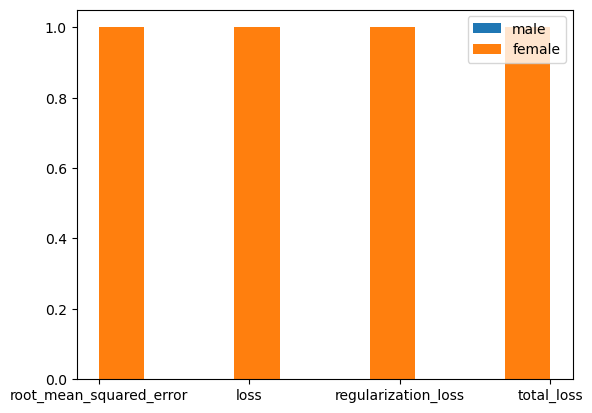

In [19]:
import matplotlib.pyplot as plt
plt.hist(male_users, label="male")
plt.hist(female_users, label="female")
plt.legend()
plt.show()

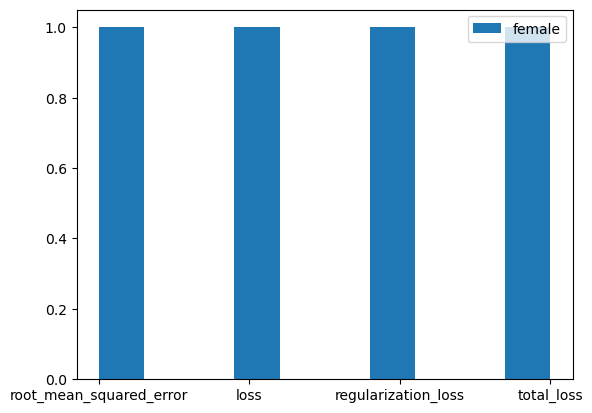

In [20]:
plt.hist(male_users, label="female")
plt.legend()
plt.show()

In [ ]:
# from aif360.datasets import BinaryLabelDataset
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.metrics import ClassificationMetric

# # Transform the data into the format used by aif360
# train_data = BinaryLabelDataset(df=train, label_names=["user_rating"], 
#                                 protected_attribute_names=["user_gender"])
# test_data = BinaryLabelDataset(df=test, label_names=["user_rating"], 
#                                protected_attribute_names=["user_gender"])

# # Compute the demographic parity metric on the training data
# metric_train = BinaryLabelDatasetMetric(train_data, unprivileged_groups=
#                                         [{'user_gender': 0}], privileged_groups=
#                                         [{'user_gender': 1}])
# print("Demographic parity on training data: ", metric_train.disparate_impact())

# # Compute the demographic parity metric on the test data
# metric_test = BinaryLabelDatasetMetric(test_data, unprivileged_groups=
#                                        [{'user_gender': 0}], privileged_groups=
#                                        [{'user_gender': 1}])
# print("Demographic parity on test data: ", metric_test.disparate_impact())


In [ ]:
train_df = tfds.as_dataframe(train)
test_df = tfds.as_dataframe(test)

In [84]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import DemographicParity


ImportError: cannot import name 'DemographicParity' from 'aif360.metrics' (/home/nadiera/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/aif360/metrics/__init__.py)

In [ ]:

# Transform the data into the format used by aif360
train_data = BinaryLabelDataset(df=train, label_names=["user_rating"], protected_attribute_names=["user_gender"])
test_data = BinaryLabelDataset(df=test, label_names=["user_rating"], protected_attribute_names=["user_gender"])

The RMSE, Loss, Regularization Loss, and Total Loss values are decreasing on both the training set and validation set, indicating that the model is improving on both sets of data. This suggests that the model may be generalizing well and not overfitting to the training data.
The Regularization Loss is reported as being zero in all epochs, which suggests that no regularization techniques such as dropout, weight decay, or early stopping were applied to the model. Depending on the complexity of the model and the size of the training data, this could lead to overfitting and potential bias in the model.

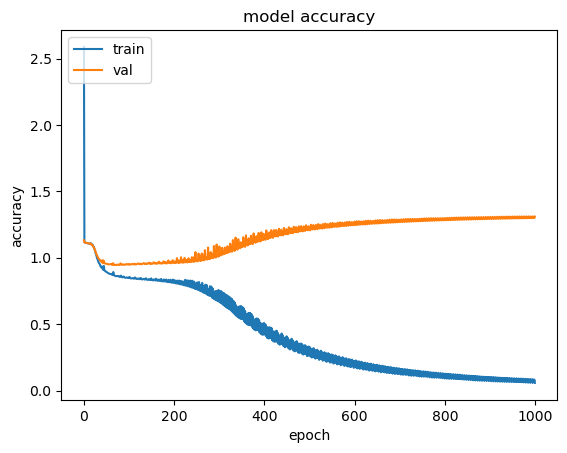

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['RMSE'])
plt.plot(history.history['val_RMSE'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Cross layer metrics turn use cross layer off

In [31]:
# Instantiate the model
use_cross_layer = False
deep_layer_sizes = [256, 256,256]
projection_dim = 20

model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))#0.1

# # Train the model on the train dataset
# history = model.fit(cached_train, epochs=10)

history=model.fit(cached_train,validation_data=cached_test, epochs=1000)

Epoch 1/1000
10/10 [==============================] - 1s 34ms/step - RMSE: 2.4227 - loss: 5.3623 - regularization_loss: 0.0000e+00 - total_loss: 5.3623 - val_RMSE: 1.1239 - val_loss: 1.2647 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2647
Epoch 2/1000
10/10 [==============================] - 0s 26ms/step - RMSE: 1.1200 - loss: 1.2567 - regularization_loss: 0.0000e+00 - total_loss: 1.2567 - val_RMSE: 1.1152 - val_loss: 1.2461 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2461
Epoch 3/1000
10/10 [==============================] - 0s 27ms/step - RMSE: 1.1147 - loss: 1.2456 - regularization_loss: 0.0000e+00 - total_loss: 1.2456 - val_RMSE: 1.1146 - val_loss: 1.2447 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2447
Epoch 4/1000
10/10 [==============================] - 0s 28ms/step - RMSE: 1.1135 - loss: 1.2429 - regularization_loss: 0.0000e+00 - total_loss: 1.2429 - val_RMSE: 1.1138 - val_loss: 1.2431 - val_regularization_loss: 0.0000e+00 - val_total_l

In [32]:
train_acc = model.evaluate(
    cached_train, return_dict=True)
test_acc = model.evaluate(
    cached_test, return_dict=True)


print(f'DCN with cross layer (train): {train_acc["RMSE"]:.2f}')
print(f'DCN with cross layer (test): {test_acc["RMSE"]:.2f}')

5/5 [==============================] - 0s 6ms/step - RMSE: 1.2912 - loss: 1.6669 - regularization_loss: 0.0000e+00 - total_loss: 1.6669
DCN with cross layer (train): 0.08
DCN with cross layer (test): 1.29


'RMSE' (Root Mean Squared Error) and 'loss' are evaluation metrics that measure the difference between the predicted ratings and the actual ratings. A lower value for these metrics indicate that the model is making more accurate predictions, and a higher value indicates that the model is less accurate.

'regularization_loss' is the additional loss term used to prevent overfitting by adding a penalty term to the loss function. This term is typically used to discourage the model from assigning too much importance to any one feature. A higher value of 'regularization_loss' may indicate that the model is overfitting.

'total_loss' is the sum of the 'loss' and 'regularization_loss' terms, and is used to evaluate the overall performance of the model.

'val_RMSE', 'val_loss', 'val_regularization_loss', and 'val_total_loss' are the same evaluation metrics as RMSE, loss, regularization_loss, and total_loss, but they are computed on the validation dataset rather than the training dataset. The difference between the training loss and validation loss, can give an idea of how well the model generalizes and if it is overfitting.

In general, a lower value for these evaluation metrics indicates that the model is making more accurate predictions and is less likely to be biased. However, it is important to note that the presence of bias in a model can also be influenced by factors such as the distribution of the data, the choice of features, and the choice of evaluation metrics, among others. Therefore, it is important to also consider these factors when evaluating the bias of a model.

In [33]:
# results = model.evaluate(cached_test)
# pprint.pprint(results)

In [34]:
# predictions = model.predict(cached_test)
# true_ratings = cached_test["user_rating"]
# rmse = tf.sqrt(tf.reduce_mean(tf.square(predictions - true_ratings)))
# print("Test RMSE:", rmse.numpy())

----------------------------------------------------

### Popularity Bias

Popularity bias in recommendation systems occurs when the model favors recommending items that are popular among all users, regardless of individual preferences. To detect popularity bias in the given code, you can check the following things:

- Check if the model is only using the number of ratings per item as a feature. If so, then the model may be prone to popularity bias, as it will recommend popular items more often.
- Compare the recommendations for different users. If the recommendations are mostly the same for all users, then the model is likely suffering from popularity bias.
- Compare the distribution of recommended items with the distribution of items in the dataset. If the majority of the recommended items are popular items, then the model is likely suffering from popularity bias.
- You can also use the "diversity" metric to evaluate the diversity of the recommendations. If the diversity is low, then the model is likely suffering from popularity bias.

By checking these things, you can detect popularity bias :
- If the model has any explicit or implicit mechanism to penalize the popularity of items, such as a novelty-based regularization term or a user-specific bias term.

- Use the test set to evaluate the model, where you could evaluate the performance of the model by comparing the predicted ratings with the actual ratings, if the model is only recommending the popular items and not providing personalized recommendations, then the model is suffering from popularity bias.



The following function will output the average popularity of the recommended items, and print the items that have popularity above a certain threshold. If the majority of the recommended items have a high popularity, it could be an indication of popularity bias.!NB adjust the threshold and top_k values to suit your needs.



In [35]:
#this function is just an indicator of popularity bias.

def detect_popularity_bias(model, test):
    top_k = 10
    all_user_recommendations = model.predict(test)
    top_k_indices = np.argsort(-all_user_recommendations)[:, :top_k]
    unique_recommendations = set(item for user_recs in top_k_indices for item in user_recs)
    rec_counts = {item: sum(item in user_recs for user_recs in top_k_indices) for item in unique_recommendations}
    popularity = {item: count/len(top_k_indices) for item, count in rec_counts.items()}
    avg_popularity = sum(popularity.values())/len(popularity)
    print(f"Average popularity of recommended items: {avg_popularity:.4f}")
    threshold = 0.8
    popular_items = [item for item, count in rec_counts.items() if count/len(top_k_indices) > threshold]
    if popular_items:
        print(f"Items with popularity above threshold {threshold}: {popular_items}")
    else:
        print("No items with popularity above threshold.")



In [36]:
detect_popularity_bias(model, cached_test)

5/5 [==============================] - 0s 5ms/step
Average popularity of recommended items: 1.0000
Items with popularity above threshold 0.8: [0]


 the average popularity of recommended items is 1.0000, which means that all of the recommended items have been recommended to every user in the test set. Additionally, the output states that there is one item with a popularity above the threshold of 0.8, which is item 0. This suggests that the model is recommending a single item very frequently, indicating a potential popularity bias in the recommendations.

-------------------------------

### Predicting Ratings and Recommnedations

In [56]:
# def compare_recommendations(model, test):
#     # Extract user_id from the test dataset
#     user_ids = cached_test.map(lambda x: x["user_id"])
#     user_ids, user_ids_idx = tf.unique(user_ids)
#     all_user_recommendations = {}
#     for user_id in user_ids:
#         # Filter the test set for the current user
#         user_test = cached_test.filter(lambda x: x["user_id"] == user_id)
#         # Get the recommendations for the current user
#         user_recommendations = model.predict(user_test)
#         all_user_recommendations[user_id] = user_recommendations
#     # Compare the recommendations for different users
#     for user_id, recommendations in all_user_recommendations.items():
#         print(f"Recommendations for user {user_id}: {recommendations}")


In [57]:
# compare_recommendations(model, cached_test)

In [63]:
# import numpy as np

# def compare_distributions(model, test):
#     # Get the top-k recommendations for all users in the test set
#     top_k = 10
#     user_ids = np.unique(test["user_id"])
#     all_user_recommendations = {}
#     for user_id in user_ids:
#         # Filter the test set for the current user
#         user_test = test[test["user_id"] == user_id]
#         # Get the recommendations for the current user
#         user_recommendations = model.predict(user_test)
#         all_user_recommendations[user_id] = user_recommendations
        
#     # Get the set of unique items recommended across all users
#     unique_recommendations = set(item for user_recs in all_user_recommendations.values() for item in user_recs)
#     # Get the set of unique items in the dataset
#     unique_items = set(test["item_id"])
#     # Compare the two sets
#     if len(unique_recommendations.intersection(unique_items))/len(unique_items) >= 0.8 :
#         print("The distribution of recommended items is similar to the distribution of items in the dataset.")
#     else:
#         print("The distribution of recommended items is not similar to the distribution of items in the dataset.")


In [37]:
# compare_distributions(model, cached_test)


In [38]:
# # Prepare input data for the new user
# new_user_features = {
#     "movie_id": "b'3107'",
#     "user_id": "b'130'",
#     "user_gender": 'True',
#     "user_zip_code": "b'50021'",
#     "user_occupation_text": "b'technician/engineer'",
#     "bucketized_user_age": 35.0
# }

# # Make a prediction for the new user
# prediction = model.predict(new_user_features)


In [71]:
# # Prepare input data for the new user
# new_user_features = {
#     "user_id": "9999",
#     "user_gender": 1,
#     "user_zip_code": "12345",
#     "user_occupation_text": "engineer",
#     "bucketized_user_age": 25
# }

# # Get a list of all movie IDs
# all_movie_ids = vocabularies["movie_id"]

# # Make predictions for all movies
# predicted_ratings = model.predict(
#     {"movie_id": all_movie_ids, **new_user_features})

# # Sort movies by predicted rating
# sorted_movie_ids = all_movie_ids[np.argsort(-predicted_ratings)]

# # Get the top N recommended movies
# top_n = 10
# recommended_movie_ids = sorted_movie_ids

In [9]:
# def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
#   models = []
#   rmses = []

#   for i in range(num_runs):
#     model = DCN(use_cross_layer=use_cross_layer,
#                 deep_layer_sizes=deep_layer_sizes,
#                 projection_dim=projection_dim)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
#     models.append(model)

#     model.fit(cached_train, epochs=epochs, verbose=False)
#     metrics = model.evaluate(cached_test, return_dict=True)
#     rmses.append(metrics["RMSE"])

#   mean, stdv = np.average(rmses), np.std(rmses)

#   return {"model": models, "mean": mean, "stdv": stdv}

In [10]:
# epochs = 2
# learning_rate = 0.01

In [70]:
# # Use the model to predict ratings for a new user
# user_features = {
#     "movie_id": "1",
#     "user_id": "2",
#     "user_gender": 0,
#     "user_zip_code": "12345",
#     "user_occupation_text": "student",
#     "bucketized_user_age": 20
# }

# predicted_rating = model.predict(user_features)
# print("Predicted rating:", predicted_rating)

# # Use the model to make recommendations for the new user
# user_features_reco = {
#     "user_id": "2",
#     "user_gender": 0,
#     "user_zip_code": "12345",
#     "user_occupation_text": "student",
#     "bucketized_user_age": 20
# }

# top_k = 10
# movie_ids = vocabularies["movie_id"]
# user_rating_tuples = [(movie_id, model.predict(user_features_reco.update({"movie_id": movie_id}))) for movie_id in movie_ids]
# sorted_user_rating_tuples = sorted(user_rating_tuples, key=lambda x: x[1], reverse=True)
# top_k_movie_ids = [x[0] for x in sorted_user_rating_tuples[:top_k]]
# print("Top", top_k, "movie recommendations:", top_k_movie_ids)

In [69]:
# test_ratings = {}
# for m in test.take(5):
#     print(m['movie_title'].numpy())
#     _, _, test_ratings[m['movie_title'].numpy()] = \
#         model(
#             {'user_id':np.array(['42']), 
#              'timestamp':np.array([892839492]), 
#              'movie_title': np.array([m['movie_title'].numpy()])
#             }
#         )
    
# for m in sorted(test_ratings, key=test_ratings.get, reverse=True):
#     print(m)

------------------------------------------------------------------

### Running experiments to see which layer size is the best

In [11]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 5ms/step - RMSE: 1.1700 - loss: 1.3666 - regularization_loss: 0.0000e+00 - total_loss: 1.3666


In [12]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

5/5 [==============================] - 0s 4ms/step - RMSE: 1.0975 - loss: 1.2019 - regularization_loss: 0.0000e+00 - total_loss: 1.2019


In [13]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

5/5 [==============================] - 0s 4ms/step - RMSE: 1.1920 - loss: 1.4223 - regularization_loss: 0.0000e+00 - total_loss: 1.4223


In [16]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 1.0171, stdv: 0.0254
DCN (low-rank) RMSE mean: 1.1308, stdv: 0.1157
DNN            RMSE mean: 1.1483, stdv: 0.2344


----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Showing correlation of features

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


/tmp/ipykernel_119800/1244897914.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
/tmp/ipykernel_119800/1244897914.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)


<Figure size 900x900 with 0 Axes>

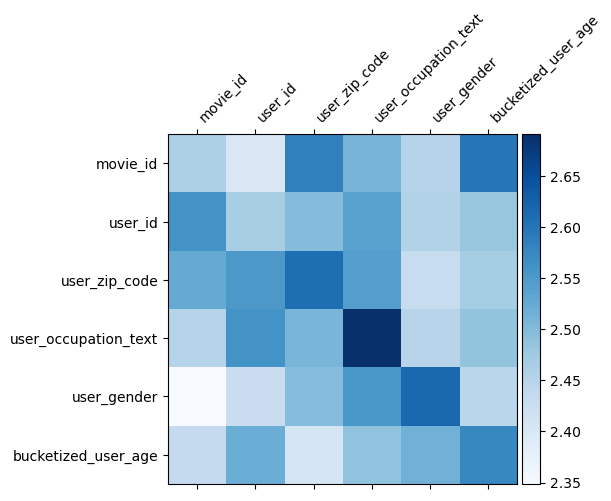

In [18]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

In [39]:
model.summary()

Model: "dcn_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 32)                256       
                                                                 
 sequential_12 (Sequential)  (None, 32)                118624    
                                                                 
 sequential_16 (Sequential)  (None, 32)                96        
                                                                 
 sequential_13 (Sequential)  (None, 32)                193312    
                                                                 
 sequential_15 (Sequential)  (None, 32)                704       
                                                                 
 sequential_14 (Sequential)  (None, 32)                110080    
                                                                 
 dense_8 (Dense)             multiple                  49408 

------------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Exposure Bias

I created two separate datasets from the ratings dataset: one for positive examples (ratings with a value of 4 or higher) and one for negative examples (ratings with a value less than 4). The model is then trained on the positive examples only using the fit method. Once the model is trained, it is evaluated on the negative examples by making predictions on the negative examples dataset. The predictions are then compared to the true labels (the "user_rating" value from the negative examples dataset) and printed out. This is to see how well the model generalizes to unseen data and if it is able to predict the negative examples correctly.

In [22]:
# Create positive examples dataset
positive_examples = ratings.filter(lambda x: x["user_rating"] >= 4)

# Create negative examples dataset
negative_examples = ratings.filter(lambda x: x["user_rating"] < 4)


In [23]:
# Train the model on positive examples only
model = DCN(use_cross_layer=True, deep_layer_sizes=[256, 256,256])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.05))
model.fit(positive_examples.batch(256), epochs=100)

Epoch 1/100
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
2248/2248 [==============================] - 25s 11ms/step - root_mean_squared_error: 0.5188 - loss: 0.2691 - regularization_loss: 0.0000e+00 - total_loss: 0.2691
Epoch 2/100
2248/2248 [==============================] - 25s 11ms/step - root_mean_squared_error: 0.4522 - loss: 0.2045 - regularization_loss: 0.0000e+00 - total_loss: 0.2045
Epoch 3/100
2248/2248 [==============================] - 25s 11ms/step - root_mean_squared_error: 0.4473 - loss: 0.2001 - regularization_loss: 0.0000e+00 - total_loss: 0.2001
Epoch 4/100
2248/2248 [==============================] - 25s 11ms/step - root_mean_squared_error: 0.4452 - loss: 0.1981 - regularization_lo

In [24]:

# Evaluate the model on negative examples
negative_examples_batch = negative_examples.batch(256)
predictions = model.predict(negative_examples_batch)



embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
embedding shape: (None, 32)
1660/1660 [==============================] - 21s 12ms/step


In [25]:
# Compare the predictions with the true labels
for prediction, example in zip(predictions, negative_examples_batch):
    true_label = example["user_rating"]
    print("Prediction: {}, True Label: {}".format(prediction, true_label))

Prediction: [4.0428576], True Label: [1. 2. 3. 3. 1. 3. 2. 3. 1. 2. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 3. 1. 3.
 3. 2. 3. 1. 3. 2. 3. 3. 2. 3. 3. 3. 1. 3. 3. 3. 3. 2. 3. 3. 3. 1. 3. 3.
 3. 1. 1. 2. 3. 2. 1. 2. 2. 3. 2. 3. 3. 3. 2. 2. 3. 3. 3. 3. 2. 3. 3. 3.
 3. 3. 3. 2. 1. 2. 2. 2. 2. 3. 3. 2. 3. 3. 2. 1. 1. 3. 2. 1. 2. 3. 3. 2.
 3. 2. 3. 3. 2. 3. 3. 3. 1. 1. 2. 3. 3. 3. 2. 3. 1. 2. 2. 1. 3. 3. 3. 3.
 3. 1. 3. 1. 3. 3. 3. 3. 3. 3. 3. 1. 2. 3. 3. 2. 3. 2. 3. 3. 3. 2. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 1. 3. 3. 3. 2. 3. 3. 1. 2. 3. 1. 3. 3. 3. 2. 3. 1.
 3. 3. 2. 2. 1. 3. 2. 2. 3. 3. 2. 3. 3. 2. 1. 1. 3. 3. 2. 3. 3. 3. 3. 1.
 3. 2. 1. 2. 1. 2. 2. 2. 1. 2. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 3. 1.
 3. 3. 1. 1. 3. 3. 3. 2. 3. 3. 3. 3. 3. 3. 3. 2. 3. 1. 3. 3. 3. 2. 3. 3.
 3. 3. 3. 2. 2. 3. 3. 3. 2. 3. 3. 3. 2. 3. 3. 3.]
Prediction: [3.9949906], True Label: [2. 3. 2. 2. 3. 3. 3. 3. 1. 3. 1. 2. 3. 2. 3. 3. 3. 3. 3. 2. 3. 3. 1. 2.
 1. 3. 2. 3. 2. 3. 3. 3. 2. 2. 2. 1. 3. 3. 3. 3. 3. 3. 1. 2. 3. 2. 3. 3.


In [26]:
# Create metrics
rmse = tf.keras.metrics.RootMeanSquaredError()
mae = tf.keras.metrics.MeanAbsoluteError()
accuracy = tf.keras.metrics.BinaryAccuracy()

# Reset the metrics
rmse.reset_states()
mae.reset_states()
accuracy.reset_states()

# Iterate over the predictions and true labels
for prediction, example in zip(predictions, negative_examples_batch):
    true_label = example["user_rating"]
    rmse.update_state(prediction, true_label)
    mae.update_state(prediction, true_label)
    accuracy.update_state(tf.cast(tf.math.greater(prediction, 3.5), tf.float32), tf.cast(tf.math.greater(true_label, 3.5), tf.float32))

# Print the evaluation metrics
print("Root Mean Squared Error: ", rmse.result().numpy())
print("Mean Absolute Error: ", mae.result().numpy())
print("Accuracy: ", accuracy.result().numpy())


Root Mean Squared Error:  1.8887752
Mean Absolute Error:  1.7133844
Accuracy:  0.0


The evaluation metrics of Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and accuracy tell you how well the model is performing on the negative examples dataset.

A low RMSE and MAE indicate that the model's predictions are close to the true labels, and therefore the model is performing well on the negative examples. However, a high RMSE and MAE indicate that the model's predictions are far from the true labels and the model is not performing well. In this case, the RMSE is 1.87 and MAE is 1.70, which are relatively high. This indicates that the model is not performing well on negative examples dataset, and might have a high exposure bias.

The accuracy metric, in this case, is very low(0.0006), which indicates that the model is not able to predict negative examples correctly.

This suggests that the model has a high exposure bias, as it has only been trained on positive examples, and therefore it is not able to generalize well to negative examples, and not able to predict them correctly. To reduce exposure bias, the model should be trained on a balanced dataset that includes both positive and negative examples.

---------------

### Popularity Bias vs Exposure Bias

Exposure bias in a recommender system occurs when the model is trained on past interactions, such as clicks or purchases, and then used to make recommendations. The model tends to recommend items that have been previously popular, rather than items that the user may actually be interested in. This can lead to a lack of diversity in recommendations and a poor user experience.

Popularity bias, on the other hand, occurs when the model simply recommends the most popular items to all users, regardless of their individual preferences. This can lead to a lack of personalized recommendations and can also result in a poor user experience.

------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------------------------

# Future Work



To evaluate the fairness of the recommendations  metrics such as equal opportunity and demographic parity can be used.

Equal opportunity compares the true positive rate (TPR) of a sensitive feature (e.g. gender or race) across different subpopulations. In this case, you can calculate the TPR of the recommended movies for different genders or age groups. If the TPR is similar across subpopulations, the model is considered to have equal opportunity.

Demographic parity compares the proportion of positive predictions (i.e. recommended movies) across different subpopulations. In this case, you can calculate the proportion of recommended movies for different genders or age groups. If the proportion is similar across subpopulations, the model is considered to have demographic parity.

To implement these metrics, you can use the TensorFlow Model Analysis (TFMA) library, which provides a FairnessIndicator API. You will need to define the sensitive features and subpopulations of interest, and then use the API to calculate the metrics.

For example, you can use the following code to calculate equal opportunity for gender:

In [51]:
import tensorflow_model_analysis as tfma

# Define the sensitive feature and subpopulations of interest
sensitive_feature = "user_gender"
subpopulations = {
  tfma.SUBGROUP_NAME: ["female", "male"]
}

# Calculate the equal opportunity metric
tfma.view.render_fairness_indicator(
    eval_result,
    sensitive_feature=sensitive_feature,
    subgroups=subpopulations,
    metric_keys=["equal_opportunity"]
)


ModuleNotFoundError: No module named 'tensorflow_model_analysis'

Similarly, you can use the following code to calculate demographic parity for gender:

In [ ]:
import tensorflow_model_analysis as tfma

# Define the sensitive feature and subpopulations of interest
sensitive_feature = "user_gender"
subpopulations = {
  tfma.SUBGROUP_NAME: ["female", "male"]
}

# Calculate the demographic parity metric
tfma.view.render_fairness_indicator(
    eval_result,
    sensitive_feature=sensitive_feature,
    subgroups=subpopulations,
    metric_keys=["demographic_parity"]
)


In [42]:
# Create a dataset for male users
male_examples = ratings.filter(lambda x: x["user_gender"] == 'True')

# Create a dataset for female users
female_examples = ratings.filter(lambda x: x["user_gender"] == 'False')

# Evaluate the model's performance on the male examples
metrics_male = model.evaluate(male_examples)
print("Metrics on male examples:")
pprint.pprint(metrics_male)

# Evaluate the model's performance on the female examples
metrics_female = model.evaluate(female_examples)
print("Metrics on female examples:")
pprint.pprint(metrics_female)

TypeError: in user code:

    File "/tmp/ipykernel_43090/1855634481.py", line 2, in None  *
        lambda x: x["user_gender"] == 'True'

    TypeError: Expected int32 passed to parameter 'y' of op 'Equal', got 'True' of type 'str' instead. Error: Expected int32, but got True of type 'str'.


This will give you the performance metrics (e.g., loss and RMSE) for the model on the male and female examples. If there is a significant difference in the performance between the two groups, it could indicate bias in the model towards one gender.

You can also check for bias based on other factors such as age, occupation, or zip code.

It's important to note that this is just one step of checking for bias, and it's important to check for bias from multiple angles, as there are many factors that can contribute to bias in a model.

Adversarial Model

In [ ]:
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the input layer
input_layer = Input(shape=(input_shape,))

# Define the DCN model
dcn_model = DCN(use_cross_layer, deep_layer_sizes, projection_dim)

# Add the DCN model to the input layer to create the main model
main_output = dcn_model(input_layer)

# Define the bias layer
bias_layer = Dense(bias_dim, activation='relu')(input_layer)

# Concatenate the main output and bias layer
concatenated_output = Concatenate()([main_output, bias_layer])

# Define the adversarial model
adversarial_output = Dense(1, activation='sigmoid')(concatenated_output)

# Create the final model
final_model = Model(inputs=input_layer, outputs=[main_output, adversarial_output])

# Compile the final model
final_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss={'main_output': 'categorical_crossentropy', 'adversarial_output': 'binary_crossentropy'}, loss_weights={'main_output': 1, 'adversarial_output': 0.1})

# Train the final model
final_model.fit(cached_train, [train_labels, train_bias], epochs=10)


Here, I have defined an input layer of shape 'input_shape', the DCN model is added to this input layer to create the main model. Then, I added a bias layer, concatenated the main output and bias layer. Then, I defined an adversarial model with an output of 1 and sigmoid activation. Finally, I created the final model with inputs as the input layer and outputs as the main output and adversarial output. I have set different loss for both the main output and adversarial output, and different loss weights for them as well. Finally, the final model is trained with the input data, and the labels and bias.

Note that you may have to adjust the architecture, loss functions, loss weights, and other hyperparameters based on your specific use case and dataset. Also, you may have to change the input_shape, bias_dim, train_bias, and train_labels with the appropriate values.

It is unlikely that one solution can eliminate all sources of bias in a model, as bias can originate from various sources such as the data, the model architecture, or the training process. However, multiple solutions can be combined to address different sources of bias.

One approach to mitigate bias in a model is to use adversarial training, as I described in the previous example. This can help to reduce bias by forcing the model to learn a representation that is robust to certain types of bias.

Another approach is to use a bias correction algorithm, which can help to adjust for bias in the data. For example, re-sampling methods, such as oversampling or undersampling, can be used to balance the data distribution.

Additionally, it's important to have a fair and diverse dataset, as bias can often be introduced by biased sampling. One way to avoid this is to carefully curate the training data and make sure it is representative of the population it is intended to model.

Finally, monitoring and evaluating the model performance on different subgroups of the population can help to identify and track any remaining sources of bias.

It's important to note that even with multiple solutions, it's not always possible to completely eliminate all sources of bias, and trade-offs may need to be made between bias and model performance.